<a href="https://colab.research.google.com/github/cagatayeskin/Data-Fitting-with-ANNs/blob/main/Nonlinear_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Fitting a Non-Linear Model to Data with Errors in Both Coordinates***

We are going to fit a non-linear model to data. Model will be in the form of double exponential decay. After creating $N_{test}$ number of data points on the curve given by model, we sample set of $\sigma_{x_i}$ and $\sigma_{y_i}$ for each point. Using variances, we sample noise values, $δx_i$ and $δy_i$ for each point from Gaussian distribution. This way we create a test data and use it as an example. To compare our results we use Orthogonal Distance Regression. Accuracy of the methods will be subject to further testing later in this notebook.

$$
y = ae^{-bx}+ce^{-dx}
$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.6.0


## Create a test data and show it on a plot with Orthogonal Distance Regression solution

In [ ]:
N_test = 75 # number of data points
sigma_X = np.random.uniform(0.15, 0.20, N_test) # sample x coordinate sigmas from uniform distribution
sigma_Y = np.random.uniform(0.15, 0.20, N_test) # sample y coordinate sigmas from uniform distribution
noise_X = np.multiply(sigma_X, np.random.randn(N_test)) # error on x data (normally distributed)
noise_Y = np.multiply(sigma_Y, np.random.randn(N_test)) # error on y data (normally distributed)
 
# True parameters of the model which will be used to generate data
a_true = 2.84
b_true = 0.47
c_true = 2.05
d_true = 0.12

X = np.linspace(0.1, 9.9, N_test) + noise_X # observed X points
Y = a_true*np.exp(-b_true*(X-noise_X)) + c_true*np.exp(-d_true*(X-noise_X)) + noise_Y # observed Y points

In [ ]:
# Orthogonal distance regression

def func(beta, x):
  a, b, c, d = beta
  return a * np.exp(-b*x) + c * np.exp(-d*x)

data = RealData(X, Y, sigma_X, sigma_Y)
model = Model(func)

odr = ODR(data, model, [3.0, 1.0, 3.0, 0.5])

odr.set_job(fit_type=0)
odr_output = odr.run()
print("Iteration 1:")
print("------------")
print("   stop reason:", odr_output.stopreason)
print("        params:", odr_output.beta)
print("          info:", odr_output.info)
print("       sd_beta:", odr_output.sd_beta)
print("sqrt(diag(cov):", np.sqrt(np.diag(odr_output.cov_beta)))

# if convergence is not reached, run again the algorithm
if odr_output.info != 1:
    print("\nRestart ODR till convergence is reached")
    i = 1
    while odr_output.info != 1 and i < 100:
        print("restart", i)
        odr_output = odr.restart()
        i += 1
    print("   stop reason:", odr_output.stopreason)
    print("        params:", odr_output.beta)
    print("          info:", odr_output.info)
    print("       sd_beta:", odr_output.sd_beta)
    print("sqrt(diag(cov):", np.sqrt(np.diag(odr_output.cov_beta)))

# Print the results and compare to least square
a_odr, b_odr, c_odr, d_odr = odr_output.beta

Iteration 1:
------------
   stop reason: ['Sum of squares convergence']
        params: [2.52066618 0.70015215 2.64505005 0.14370618]
          info: 1
       sd_beta: [0.53695672 0.22826633 0.64030271 0.02976746]
sqrt(diag(cov): [0.52705413 0.22405663 0.6284942  0.02921848]


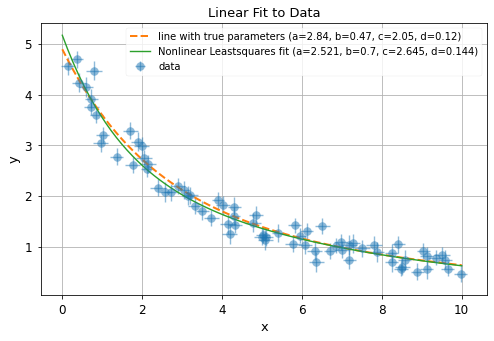

In [ ]:
# Create a figure
fig = plt.figure(figsize=(8, 5))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data (Choose either one of below)
#plt.plot(X, Y, 'o', label='data', ms=8.5, alpha=0.5)
plt.errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=8.5, alpha=0.5) # error bars show SD

# Plotting the line with true parameters
x_plot = np.linspace(0.0, 10.0, N_test)
y_true_plot = a_true*np.exp(-b_true*x_plot) + c_true*np.exp(-d_true*x_plot)
plt.plot(x_plot, y_true_plot, '--', linewidth = 2.0, label=('line with true parameters (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ', c=' + str(c_true) +
                                                            ', d=' + str(d_true) +')'))

y_ODR_fit = a_odr*np.exp(-b_odr*x_plot) + c_odr*np.exp(-d_odr*x_plot)
# Plotting Nonlinear Leastquares fit
plt.plot(x_plot, y_ODR_fit, label=('Nonlinear Leastsquares fit (a=' + str(np.round(a_odr, 3)) +
                                                            ', b=' + str(np.round(b_odr, 3)) + ', c=' + str(np.round(c_odr, 3)) +
                                                            ', d=' + str(np.round(d_odr, 3)) +')') )

# Plot specs
plt.tick_params(labelsize=12)
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.title('Linear Fit to Data', fontsize = 13)
plt.legend(fontsize = 10)
plt.grid()

# **Fitting a Model to Data using the Artificial Neural Network (ANN)**
In this part, we start by defining the ANN, then we provide weights of the pre-trained network so that there isn't a necessary training process. Training data generation is held the same way as we did in the first part of the notebook while producing a test data. But this time we create large number of different models from which we sample data with different number of points. We also provide training part. To supply the data to ANN, we first give it the appropriate shape, so before the testing we do the preprocessing part. After that, we continue further testing by using three different models. At the end, we find the parameter uncertainties and provide a metric to show accuracy of the ANN's predictions.

## Build the ANN for non-linear model define its architecture

In [ ]:
model = keras.Sequential([
    layers.InputLayer(input_shape = (None, 4)),
    layers.LSTM(32, activation = 'tanh', return_sequences=True),
    layers.LSTM(16, activation = 'tanh', return_sequences=False),
    layers.Dense(16, activation = 'tanh'),
    layers.Dense(8, activation = 'tanh'),
    layers.Dense(4),
  ])
model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(0.004))

##Download trained network weights

Training data was created from models with boundaries
$$
1.0<a<3.0
$$
$$
0.0<b<1.0
$$
$$
0.5<c<3.0
$$
$$
-0.5<d<0.5
$$


In [ ]:
!wget https://drive.google.com/uc?id=1geTH6zLfrBl8cb21NzKL94nH07VAk4ZI&export=download 
model.load_weights('uc?id=1geTH6zLfrBl8cb21NzKL94nH07VAk4ZI')

--2021-10-09 19:14:16--  https://drive.google.com/uc?id=1geTH6zLfrBl8cb21NzKL94nH07VAk4ZI
Resolving drive.google.com (drive.google.com)... 173.194.216.138, 173.194.216.102, 173.194.216.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1etbd2qb11ms85jr7bgugjuecuaaka2n/1633806825000/06440322669498725628/*/1geTH6zLfrBl8cb21NzKL94nH07VAk4ZI [following]
--2021-10-09 19:14:16--  https://doc-14-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1etbd2qb11ms85jr7bgugjuecuaaka2n/1633806825000/06440322669498725628/*/1geTH6zLfrBl8cb21NzKL94nH07VAk4ZI
Resolving doc-14-9s-docs.googleusercontent.com (doc-14-9s-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connecting to doc-14-9s-docs.googleusercontent.com (doc-14-9s-docs.googleusercontent.com)|1

##Training process (If you downloaded weights you can skip this)

Training data that we are going to create will especially be important in here because, even a small change in model parameters change shape of the function drastically. We need to choose upper and lower bounds of model parameters carefully that their interval include the true paramaters. But choosing big interval can cause a low quality training data. So, intervals must be relatively small and they must include true parameters of the model.

In [ ]:
J = 100000 # number of training models

a_train = np.linspace(1.0, 3.0, J)
b_train = np.linspace(0.0, 1.0, J)
c_train = np.linspace(0.5, 3.0, J)
d_train = np.linspace(-0.5, 0.5, J)

# Shuffling the arrays to get random a and b pairs
np.random.shuffle(a_train)
np.random.shuffle(b_train)
np.random.shuffle(c_train)
np.random.shuffle(d_train)

def data_set(N, a, b, c, d):
  sigma_x = np.random.uniform(0.15, 0.20, N) # sample x coordinate sigmas from uniform distribution
  sigma_y = np.random.uniform(0.15, 0.20, N) # sample y coordinate sigmas from uniform distribution
  noise_x = np.multiply(sigma_x, np.random.randn(N)) # error on x data (normally distributed)
  noise_y = np.multiply(sigma_y, np.random.randn(N)) # error on y data (normally distributed) 
  x = np.linspace(0.1, 9.9, N) + noise_x
  y = a*np.exp(-b*(x-noise_x)) + c*np.exp(-d*(x-noise_x)) + noise_y
  training_features = np.zeros((N, 4))
  for i in range(N):
    for k in range(1):
      training_features[i,k] = x[i]
      training_features[i,k+1] = y[i]
      training_features[i,k+2] = sigma_x[i]
      training_features[i,k+3] = sigma_y[i]
  return(training_features)

In [ ]:
training_data = []
training_labels = np.zeros((J,4))

for j in range(J):
  N = np.random.randint(10,100)
  training_data.append(data_set(N, a_train[j], b_train[j], c_train[j], d_train[j]))
  training_labels[j,0] = a_train[j]
  training_labels[j,1] = b_train[j]
  training_labels[j,2] = c_train[j]
  training_labels[j,3] = d_train[j]

In [ ]:
# Manually split dataset into training and validation sets
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(training_data,
                                                    training_labels,
                                                    test_size=0.20)
train_features = tf.ragged.constant(train_features)
val_features = tf.ragged.constant(val_features)

In [ ]:
%%time
history = model.fit(
    train_features, train_labels,
    validation_data = (val_features, val_labels),
    verbose=1, epochs=50)

Epoch 1/50
2500/2500 [==============================] - 242s 95ms/step - loss: 0.1336 - val_loss: 0.0885
Epoch 2/50
2500/2500 [==============================] - 239s 96ms/step - loss: 0.0860 - val_loss: 0.0840
Epoch 3/50
2500/2500 [==============================] - 246s 98ms/step - loss: 0.0789 - val_loss: 0.0758
Epoch 4/50
2500/2500 [==============================] - 240s 96ms/step - loss: 0.0723 - val_loss: 0.0710
Epoch 5/50
2500/2500 [==============================] - 239s 96ms/step - loss: 0.0684 - val_loss: 0.0653
Epoch 6/50
2500/2500 [==============================] - 255s 102ms/step - loss: 0.0669 - val_loss: 0.0667
Epoch 7/50
2500/2500 [==============================] - 239s 96ms/step - loss: 0.0653 - val_loss: 0.0653
Epoch 8/50
2500/2500 [==============================] - 240s 96ms/step - loss: 0.0645 - val_loss: 0.0639
Epoch 9/50
2500/2500 [==============================] - 238s 95ms/step - loss: 0.0637 - val_loss: 0.0639
Epoch 10/50
2500/2500 [==============================]

In [ ]:
cd MyDrive

/content/drive/MyDrive


In [ ]:
model.save_weights('nonlinear_fit1.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          4736      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
Total params: 8,316
Trainable params: 8,316
Non-trainable params: 0
_________________________________________________________________


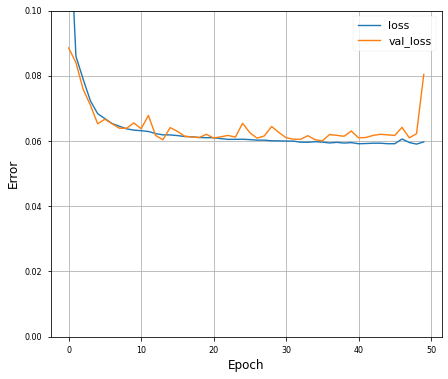

In [ ]:
def plot_loss(history):
    fig = plt.figure(figsize=(7, 6))
    plt.style.use('seaborn-paper')
    plt.rc('font', family='sans-serif')  
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.1])
    plt.xlabel('Epoch', fontsize = 12)
    plt.ylabel('Error', fontsize = 12)
    plt.legend()
    plt.grid(True)
    plt.legend(fontsize = 11)
plot_loss(history)

## Make predictions on test data

### Give appropriate shape to the test data that is created at the beginning of the notebook and make a fit using ANN and ODR

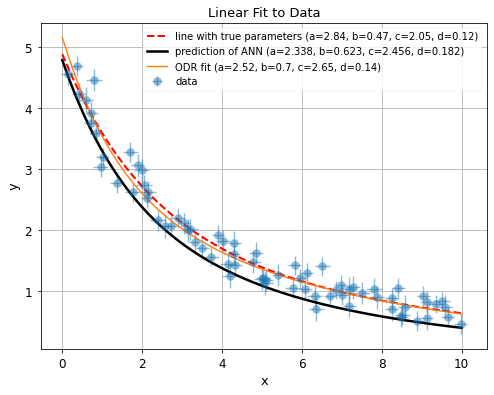

In [ ]:
main = np.zeros((1, N_test, 4))

for i in range(N_test):
    main[0,i,0] = X[i]
    main[0,i,1] = Y[i]
    main[0,i,2] = sigma_X[i]
    main[0,i,3] = sigma_Y[i]

a_fit_DNN = model.predict(main)[0,0]
b_fit_DNN = model.predict(main)[0,1]
c_fit_DNN = model.predict(main)[0,2]
d_fit_DNN = model.predict(main)[0,3]

# Create a figure
fig = plt.figure(figsize=(8, 6))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data (Choose either one of below)
#plt.plot(X, Y, 'o', label='data', ms=18.5, alpha=0.2)
plt.errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=8.5, alpha=0.5) # error bars show SD

# Plotting the line with true parameters
plt.plot(x_plot, y_true_plot, '--', linewidth = 2.0, label=('line with true parameters (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ', c=' + str(c_true)  + ', d=' + str(d_true) + ')'), color = 'red')

# Plotting predictions of DNN
y_DNN = a_fit_DNN*np.exp(-b_fit_DNN*x_plot) + c_fit_DNN*np.exp(-d_fit_DNN*x_plot)
plt.plot(x_plot, y_DNN, linewidth = 2.5, label = ('prediction of ANN (a=' + str(np.round(a_fit_DNN, 3)) +
                                                  ', b=' + str(np.round(b_fit_DNN, 3)) + ', c=' + str(np.round(c_fit_DNN, 3)) +
                                                  ', d=' + str(np.round(d_fit_DNN, 3)) + ')'), color = 'black')

# Plotting Nonlinear Leastquares fit
plt.plot(x_plot, y_ODR_fit, label=('ODR fit (a=' + str(np.round(a_odr, 2)) +
                                                            ', b=' + str(np.round(b_odr, 2)) + ', c=' + str(np.round(c_odr, 2)) +
                                                            ', d=' + str(np.round(d_odr, 2)) +')') )

# Plot specs
plt.tick_params(labelsize=12)
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.title('Linear Fit to Data', fontsize = 13)
plt.legend(fontsize = 10)
plt.grid()

## Now, create three different test data from different models and make predictions on them using trained ANNs. We also show predictions obtained with ODR.


In [ ]:
# Choose parameters
true_params = np.zeros([3,4])

# True parameters of the models
true_params[0,0] = 2.84
true_params[0,1] = 0.77
true_params[0,2] = 1.83
true_params[0,3] = 0.10

true_params[1,0] = 1.26
true_params[1,1] = 0.28
true_params[1,2] = 2.91
true_params[1,3] = 0.45

true_params[2,0] = 1.95
true_params[2,1] = 0.42
true_params[2,2] = 1.04
true_params[2,3] = 0.31

data_point_nums = [85,45,25] # number of data points

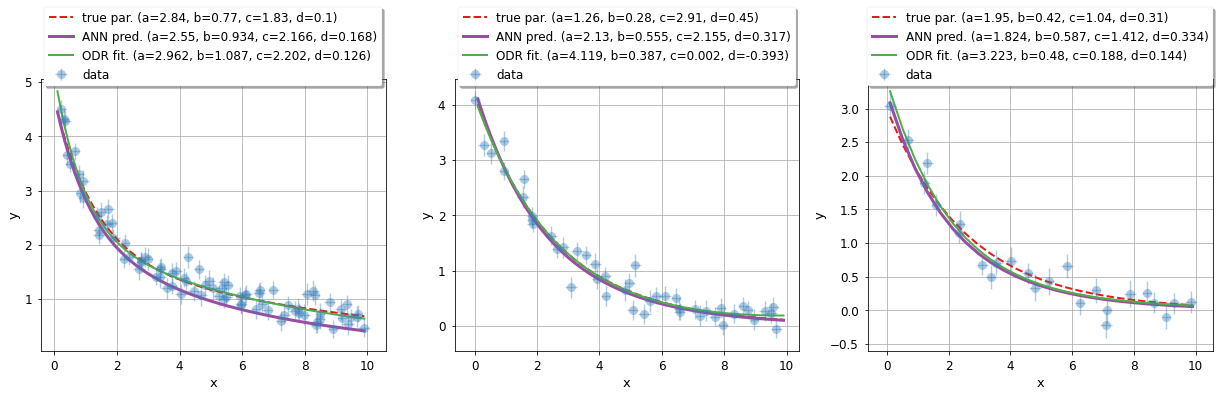

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize = (21,5))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

def triple(a, b, c, d, num, N):
  sigma_X = np.random.uniform(0.15, 0.20, N) # sample x coordinate sigmas from uniform distribution
  sigma_Y = np.random.uniform(0.15, 0.20, N) # sample y coordinate sigmas from uniform distribution
  noise_X = np.multiply(sigma_X, np.random.randn(N)) # error on x data (normally distributed)
  noise_Y = np.multiply(sigma_Y, np.random.randn(N)) # error on y data (normally distributed)
  X = np.linspace(0.1, 9.9, N) + noise_X # observed X points
  Y = a*np.exp(-b*(X-noise_X)) + c*np.exp(-d*(X-noise_X)) + noise_Y # observed Y points

  def odr_fit():
    def func(beta, x):
      a, b, c, d = beta
      return a * np.exp(-b*x) + c * np.exp(-d*x)

    data = RealData(X, Y, sigma_X, sigma_Y)
    model = Model(func)

    odr = ODR(data, model, [2.0, 0.5, 1.75, 0.0])

    odr.set_job(fit_type=0)
    odr_output = odr.run()

    if odr_output.info != 1:
        print("\nRestart ODR till convergence is reached")
        j = 1
        while odr_output.info != 1 and j < 100:
            print("restart", j)
            odr_output = odr.restart()
            j += 1

    a_odr, b_odr, c_odr, d_odr = odr_output.beta
    return(a_odr, b_odr, c_odr, d_odr)

  data_ANN = np.zeros((1, N, 4))
  for i in range(N):
    data_ANN[0,i,0] = X[i]
    data_ANN[0,i,1] = Y[i]
    data_ANN[0,i,2] = sigma_X[i]
    data_ANN[0,i,3] = sigma_Y[i]

  x_plot = np.linspace(0.1, 9.9, N)
  y_true_plot = a*np.exp(-b*x_plot) + c*np.exp(-d*x_plot)

  odr_params = odr_fit()

  y_ODR_fit = odr_params[0]*np.exp(-odr_params[1]*x_plot) + odr_params[2]*np.exp(-odr_params[3]*x_plot)

  a_ANN = model.predict(data_ANN)[0,0]
  b_ANN = model.predict(data_ANN)[0,1]
  c_ANN = model.predict(data_ANN)[0,2]
  d_ANN = model.predict(data_ANN)[0,3]
  y_ANN = a_ANN*np.exp(-b_ANN*x_plot) + c_ANN*np.exp(-d_ANN*x_plot)

  axs[num].errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=9.0, alpha=0.4, color = '#377eb8') # error bars show SD
  axs[num].plot(x_plot, y_true_plot, '--', linewidth = 2, label=('true par. (a=' + str(a) +
                                                                       ', b=' + str(b) + ', c=' + str(c) + ', d=' + str(d) +  ')' ), color = '#e41a1c')
  axs[num].plot(x_plot, y_ANN, linewidth = 3, label = ('ANN pred. (a=' + str(np.round(a_ANN, 3)) +
                                                          ', b=' + str(np.round(b_ANN, 3)) +
                                                        ', c=' + str(np.round(c_ANN, 3)) + ', d=' + str(np.round(d_ANN, 3)) + ')'), color = '#984ea3')
  
  axs[num].plot(x_plot, y_ODR_fit, linewidth = 2, label = ('ODR fit. (a=' + str(np.round(odr_params[0], 3)) +
                                                          ', b=' + str(np.round(odr_params[1], 3)) +
                                                        ', c=' + str(np.round(odr_params[2], 3)) + ', d=' + str(np.round(odr_params[3], 3)) + ')'), color = '#4daf4a')  

  axs[num].set_xlabel('x', fontsize = 13)
  axs[num].set_ylabel('y', fontsize = 13)

  axs[num].tick_params(labelsize=12)
  axs[num].legend(fontsize = 12, ncol=1, shadow=True, fancybox=True, loc='lower center', bbox_to_anchor=(0.5, 0.95))
  axs[num].grid()
  return()

for k in range(3):
  n = data_point_nums[k]
  triple(true_params[k,0], true_params[k,1], true_params[k,2], true_params[k,3], k, n)